# Building a Machine Translation System with Forte 



## Why use Forte? 
  
* Breaks down complex problems into composable pipelines 
* Enables inter-operations across tasks through a unified data format 
* Supports easy customization for different domains 
* Make the program easier to inspect and debug with **data pack**:
 * Forte helps demystify data lineage and increase the traceability of how data flows along the pipeline and how features are generated to interface data to model. Similar to a cargo ship that loads and transports goods from one port to another, a data pack carries information when passing each module and updates the ontology states along the way. 
* Compatible with popular 3rd party libraries

Run the following command to install all the required dependencies for this tutorial:

In [ ]:
!pip install forte==0.2.0 forte.nltk transformers==4.16.2 torch==1.7.0 requests sentencepiece

## Start with the Reader 

All pipelines need a reader to read and parse input data. To make our pipeline read queries from the user’s command-line terminal, use the `TerminalReader` class provided by Forte. `TerminalReader` transforms the user’s query into a DataPack object, which is a unified data format for NLP that makes it easy to connect different NLP tools together as Forte Processors.


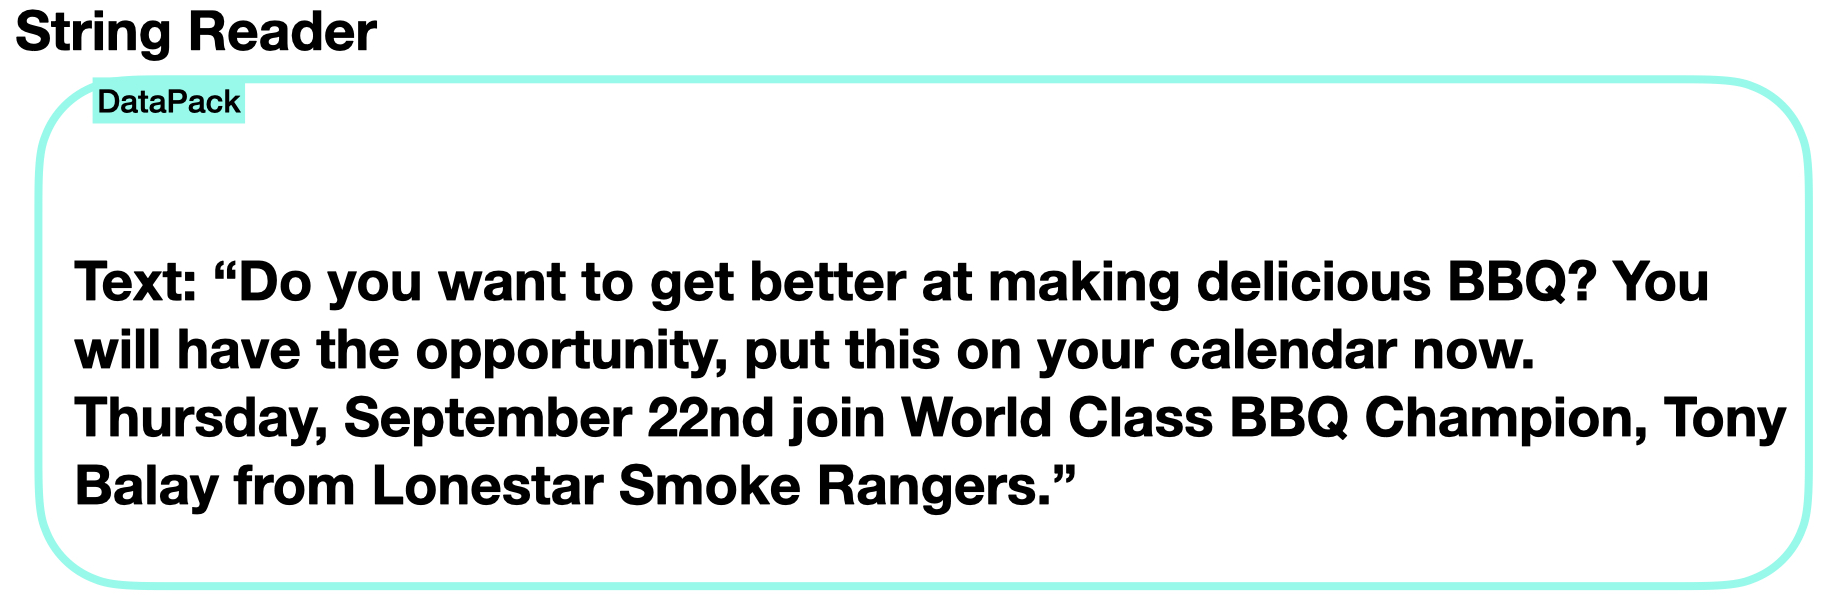

In [ ]:
from forte import Pipeline
from forte.data.readers import TerminalReader
pipeline: Pipeline = Pipeline()
pipeline.set_reader(TerminalReader())


To run the pipeline consisting of the single `TerminalReader`, call `process_dataset` which will return an iterator of DataPack objects. The second line in the following code snippet retrieves the first user query from the TerminalReader. 

In [ ]:
pipeline.initialize() 
datapack = next(pipeline.process_dataset())
print(datapack.text) 

## Add a pre-built Forte processor to the pipeline 
A Forte Processor takes DataPacks as inputs, processes them, and stores its outputs in DataPacks. The processors we are going to use in this section are all PackProcessors, which expect exactly one DataPack as input and store its outputs back into the same DataPack. The following two lines of code shows how a pre-built processor NLTKSentenceSegmenter is added to our pipeline.

In [ ]:
from fortex.nltk.nltk_processors import NLTKSentenceSegmenter
pipeline.add(NLTKSentenceSegmenter())

When we run the pipeline, the `NLTKSentenceSegmenter` processor will split the user query into sentences and store them back to the DataPack created by TerminalReader. The code snippet below shows how to get all the sentences from the first query.
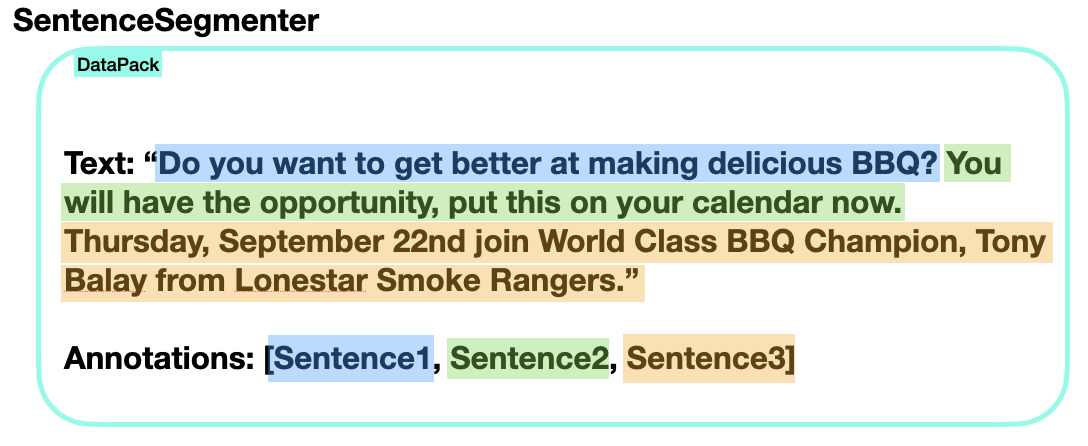

In [ ]:
from ft.onto.base_ontology import Sentence
pipeline.initialize()
for sent in next(pipeline.process_dataset()).get(Sentence):
    print(sent.text)

### Ontology
`Sentence` is a pre-defined ontology provided by Forte and it is used by `NLTKSentenceSegmenter` to annotate each sentence in text. Forte is built on top of an Ontology system, which defines the relations between NLP annotations, for example, the relation between words and documents, or between two words. This is the core for Forte. The ontology can be specified via a JSON format. And tools are provided to convert the ontology into production code (Python).
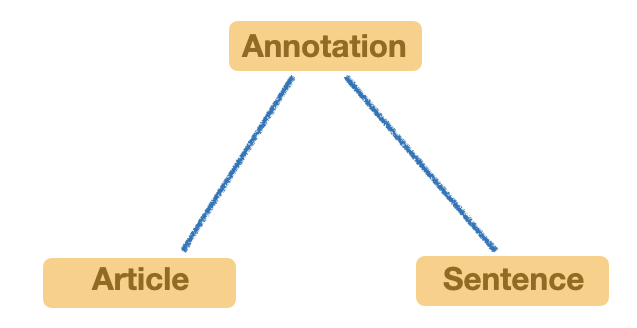
We can also define customized ontologies:

In [ ]:
from dataclasses import dataclass
from forte.data.ontology.top import Annotation
from typing import Optional

@dataclass
class Article(Annotation):

    language: Optional[str]

    def __init__(self, pack, begin: int, end: int):
        super().__init__(pack, begin, end)
        self.language: Optional[str] = None

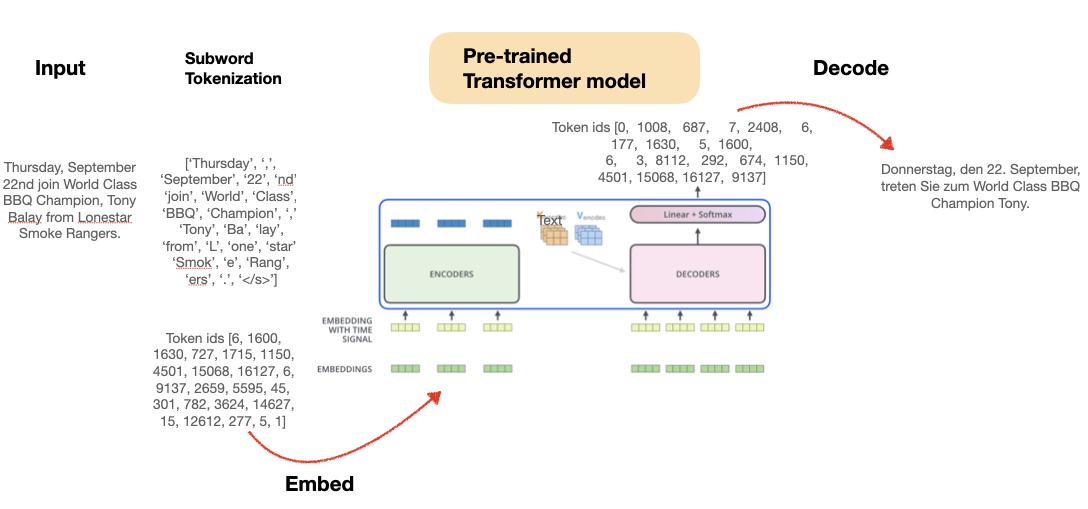

## Create a Machine Translation Processor 

In forte, we have a generic class `PackProcessor` that wraps model and inference-related components and behaviors to process `DataPack`. Therefore, we need to create a class that inherits the generic method from `PackProcessor`. Then we have a class definition 
`class MachineTranslationProcessor(PackProcessor)`.


### initialization of needed components:
1. Users need to consider initializing all needed NLP components for the inference task such as tokenizer and model. It's like a regular python class that we initialize them as class variables. For example, we initialize the model as `self.model = T5ForConditionalGeneration.from_pretrained(model_name)`.
2. User also need to specify all configuration in `configs`, a dictionary-like object that specifies configurations of all components such as model name and the path of `output_folder`. And we pass it into `initialize()` function which initializes the processor. Therefore, we have `def initialize(self, resources: Resources, configs: Config)` in `class MachineTranslationProcessor(PackProcessor)` beginner can ignore `resources` parameter and focus on `configs`.

```python
def initialize(self, resources: Resources, configs: Config):
    super().initialize(resources, configs)

    # Initialize the tokenizer and model
    model_name: str = self.configs.pretrained_model
    self.tokenizer = T5Tokenizer.from_pretrained(model_name)
    self.model = T5ForConditionalGeneration.from_pretrained(model_name)
    self.task_prefix = "translate English to German: "
    self.tokenizer.padding_side = "left"
    self.tokenizer.pad_token = self.tokenizer.eos_token
```

### MT operations on datapack
After the initialization, we already have the needed NLP components. We need to consider several MT behaviors based on forte DataPack.

0. Pre-process text data
    1. retrieve text data from datapack (given that it already reads data from the data source).  `input_pack.text`
    2. since T5 has a better performance given a task prompt, we also want to include the prompt in our data. `input_text = self.task_prefix + input_pack.text`

1. Tokenization that transforms input text into sequences of tokens and token ids. `inputs = self.tokenizer(input_text)`

2. Generate output sequences from model. `output_sequences = self.model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], do_sample=False,)`

3. Decode output token ids into sentences using the tokenizer. `outputs = self.tokenizer.batch_decode(output_sequences, skip_special_tokens=True)`



The generic method to process `DataPack` is `_process(self, input_pack: DataPack)`. It should tokenize the input text, use the model class to make an inference, decode the output token ids, and finally writes the output to a target file.


```python
def _process(self, input_pack: DataPack):
    # en2de machine translation 
    inputs = self.tokenizer([
        self.task_prefix + sentence.text
        for sentence in input_pack.get(Sentence)
    ], return_tensors="pt", padding=True)

    output_sequences = self.model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        do_sample=False,
    )

    outputs = self.tokenizer.batch_decode(
        output_sequences, skip_special_tokens=True
    )
    input_pack.set_text(input_pack.text + '\n' + ''.join(outputs))
```

Given what we discussed, we have a processor class below, and we need to add it to the pipeline after defining it.

In [ ]:
from forte.data import DataPack
from forte.data.readers import StringReader
from forte.processors.base import PackProcessor
from transformers import T5Tokenizer, T5ForConditionalGeneration

class MachineTranslationProcessor(PackProcessor):
    """
    Translate the input text and output to a file.
    """
    def initialize(self, resources, configs):
        super().initialize(resources, configs)

        # Initialize the tokenizer and model
        model_name: str = self.configs.pretrained_model
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.task_prefix = "translate English to German: "
        self.tokenizer.padding_side = "left"
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def _process(self, input_pack: DataPack):
        # en2de machine translation 
        inputs = self.tokenizer([
            self.task_prefix + sentence.text
            for sentence in input_pack.get(Sentence)
        ], return_tensors="pt", padding=True)

        output_sequences = self.model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            do_sample=False,
        )

        output = ''.join(self.tokenizer.batch_decode(
            output_sequences, skip_special_tokens=True
        ))
        src_article: Article = Article(input_pack, 0, len(input_pack.text))
        src_article.language = "en"

        input_pack.set_text(input_pack.text + '\n\n' + output)
        tgt_article: Article = Article(input_pack, len(input_pack.text) - len(output), len(input_pack.text))
        tgt_article.language = "de"

    @classmethod
    def default_configs(cls):
        return {
            "pretrained_model": "t5-small"
        }

input_string: str = "Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers."
pipeline: Pipeline = Pipeline[DataPack]()
pipeline.set_reader(StringReader())
pipeline.add(NLTKSentenceSegmenter())
pipeline.add(MachineTranslationProcessor())
pipeline.initialize()
for datapack in pipeline.process_dataset([input_string]):
    for article in datapack.get(Article):
        print(article.language + ": " + article.text)

## A better way to store source and target text: MultiPack 
The above step outputs a DataPack which is good for holding data about one specific piece of text. A complicated pipeline like the one we are building now may need multiple DataPacks to be passed along the pipeline and this is where MultiPack can help. MultiPack manages a set of DataPacks that can be indexed by their names. `MultiPackBoxer` is a simple Forte processor that converts a DataPack into a MultiPack by making it the only DataPack in there. A name can be specified via the config. We use it to wrap DataPack that contains source sentence.

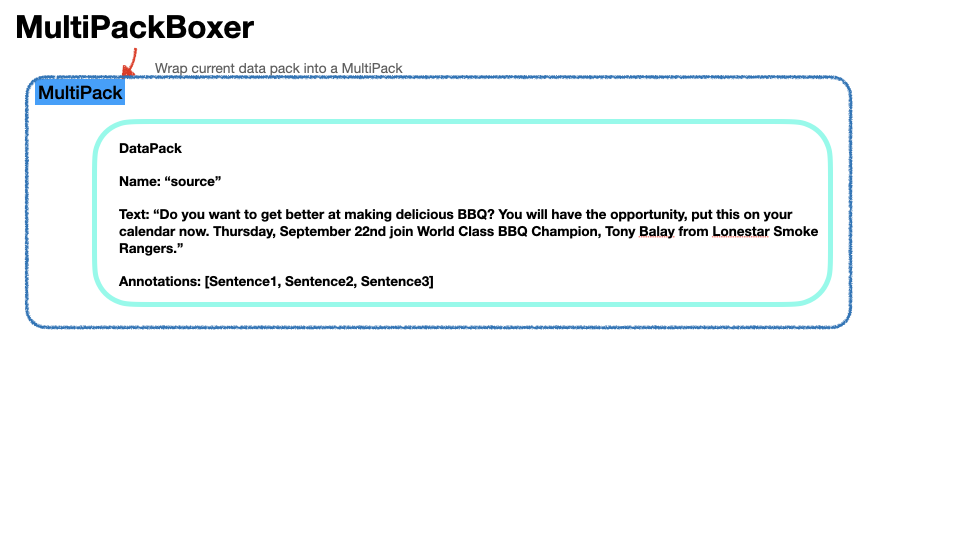

Then `MachineTranslationMPProcessor` writes the output sentence into a target DataPack.

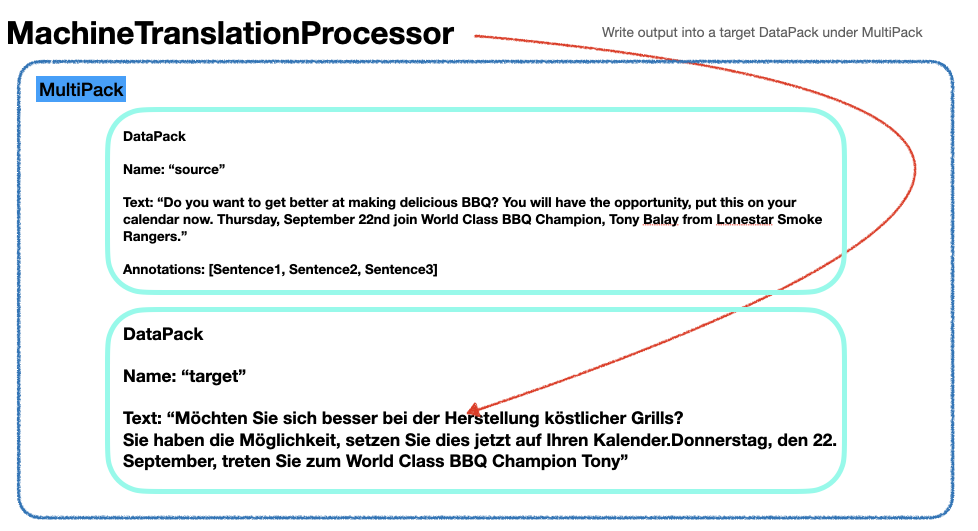

In [ ]:
from forte.data import MultiPack
from forte.processors.base import MultiPackProcessor
from forte.data.caster import MultiPackBoxer

class MachineTranslationMPProcessor(MultiPackProcessor):
    """
    Translate the input text and output to a file.
    """
    def initialize(self, resources, configs):
        super().initialize(resources, configs)

        # Initialize the tokenizer and model
        model_name: str = self.configs.pretrained_model
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.task_prefix = "translate English to German: "
        self.tokenizer.padding_side = "left"
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def _process(self, input_pack: MultiPack):
        source_pack: DataPack = input_pack.get_pack("source")
        target_pack: DataPack = input_pack.add_pack("target")

        # en2de machine translation 
        inputs = self.tokenizer([
            self.task_prefix + sentence.text
            for sentence in source_pack.get(Sentence)
        ], return_tensors="pt", padding=True)

        output_sequences = self.model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            do_sample=False,
        )

        for output in self.tokenizer.batch_decode(
            output_sequences, skip_special_tokens=True
        ):
            target_pack.set_text(target_pack.text + output)
            text_length: int = len(target_pack.text)
            Sentence(target_pack, text_length - len(output), text_length)

    @classmethod
    def default_configs(cls):
        return {
            "pretrained_model": "t5-small",
        }

input_string: str = "Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers."
nlp: Pipeline = Pipeline[DataPack]()
nlp.set_reader(StringReader())
nlp.add(NLTKSentenceSegmenter())
nlp.add(MultiPackBoxer(), config={"pack_name": "source"})
nlp.add(MachineTranslationMPProcessor(), config={
    "pretrained_model": "t5-small"
})
nlp.initialize()
for multipack in nlp.process_dataset([input_string]):
    print("Source Text: " + multipack.get_pack("source").text)
    print("\nTarget Text: " + multipack.get_pack("target").text)

## New Requirement: Handle HTML data 

In the previous step, the input string is just a simple paragraph made up of several sentences. However, in many cases, we might need to handle data with structural information, such HTML or XML. When the input is a string of raw HTML data, the machine translation pipeline above may not work as expected:

In [ ]:
html_input: str = """
<!DOCTYPE html>
<html>
    <head><title>Beginners BBQ Class.</title></head>
    <body>
    <p>Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers.</p>
    </body>
</html>
"""
nlp.initialize()
for multipack in nlp.process_dataset([html_input]):
    print("Source Text: " + multipack.get_pack("source").text)
    print("\nTarget Text: " + multipack.get_pack("target").text)

We can see that the original HTML structure is broken in the translated output.

## How to preserve HTML tags/structures

In order to handle structured data like HTML, we will need to update our current design of pipeline. Luckily, Forte pipelines are highly modular, we can simply insert two new processors without updating the previous pipeline.
We first need a HTML cleaner to parse all the HTML tags from input string. Picture below shows the effect of tag remover.
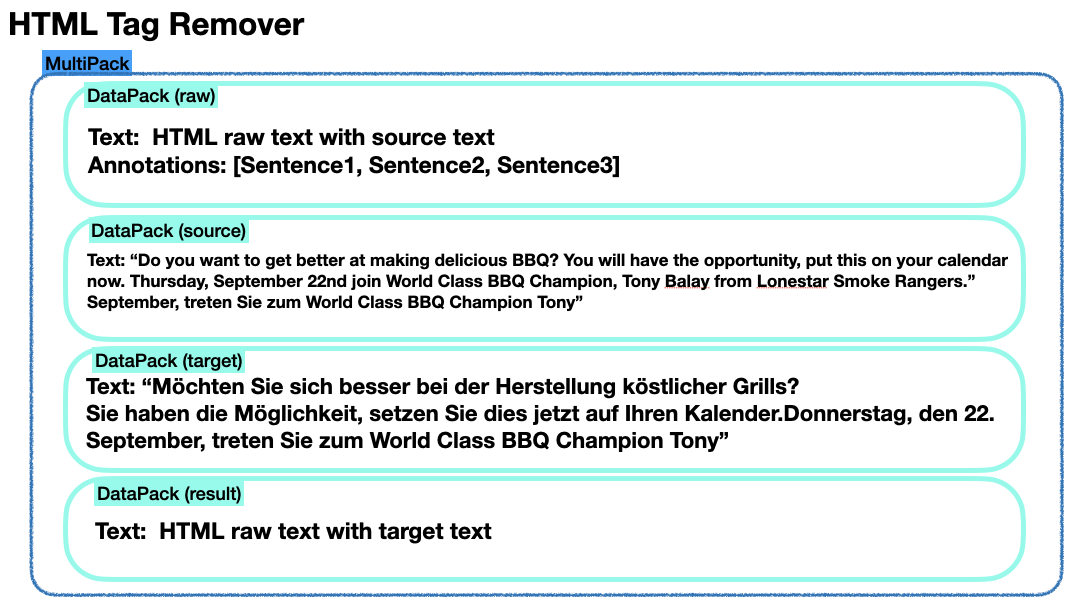

After the translation is finished, we will also need to recover the HTML structure from the unstructured translation output. Picture below shows replace one source sentence with one target sentence given the target sentence is ready.
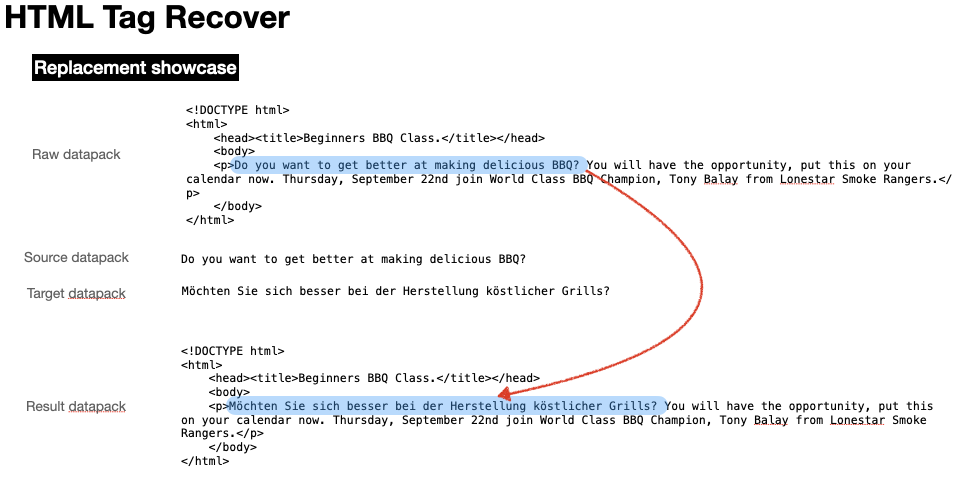

In [ ]:
from forte.data import NameMatchSelector
from forte.data.readers.html_reader import ForteHTMLParser

class HTMLTagCleaner(MultiPackProcessor):
    
    def initialize(self, resources, configs):
        super().initialize(resources, configs)
        self._parser = ForteHTMLParser()

    def _process(self, input_pack: MultiPack):
        raw_pack: DataPack = input_pack.get_pack("raw")
        source_pack: DataPack = input_pack.add_pack("source")
        
        self._parser.feed(raw_pack.text)
        cleaned_text: str = raw_pack.text
        for span, _ in self._parser.spans:
            cleaned_text = cleaned_text.replace(
                raw_pack.text[span.begin:span.end], ''
            )
        source_pack.set_text(cleaned_text)
        
class HTMLTagRecovery(MultiPackProcessor):

    def _process(self, input_pack: MultiPack):
        raw_pack: DataPack = input_pack.get_pack("raw")
        source_pack: DataPack = input_pack.get_pack("source")
        target_pack: DataPack = input_pack.get_pack("target")
        result_pack: DataPack = input_pack.add_pack("result")
        result_text: str = raw_pack.text
        for sent_src, sent_tgt in zip(source_pack.get(Sentence), target_pack.get(Sentence)):
            result_text = result_text.replace(sent_src.text, sent_tgt.text)
        result_pack.set_text(result_text)
        
# Pipeline with HTML handling
pipeline: Pipeline = Pipeline[DataPack]()
pipeline.set_reader(StringReader())
pipeline.add(MultiPackBoxer(), config={"pack_name": "raw"})
pipeline.add(HTMLTagCleaner())
pipeline.add(
    NLTKSentenceSegmenter(),
    selector=NameMatchSelector(),
    selector_config={"select_name": "source"}
)
pipeline.add(MachineTranslationMPProcessor(), config={
    "pretrained_model": "t5-small"
})
pipeline.add(HTMLTagRecovery())

pipeline.initialize()
for multipack in pipeline.process_dataset([html_input]):
    print(multipack.get_pack("raw").text)
    print(multipack.get_pack("result").text)

### Selector
In the code snippet above, we utilize a `NameMatchSelector` to select one specific DataPack from the MultiPack based on its reference name `select_name`. This allows `NLTKSentenceSegmenter` to process only the specified DataPack.

## Replace our MT model with online translation API
Forte also allows us to update the translation model and integrate it seamlessly to the original pipeline. For example, if we want to offload the translation task to an online service, all we need to do is to update the translation processor. There is no need to change other components in the pipeline.

In [ ]:
# You can get your own API key through https://fanyi-api.baidu.com/
api_key = input("Enter your API key here:")

In [ ]:
import requests
import uuid

class OnlineMachineTranslationMPProcessor(MultiPackProcessor):
    """
    Translate the input text and output to a file use online translator api.
    """
    def initialize(self, resources, configs):
        super().initialize(resources, configs)
        self.url = configs.endpoint + configs.path
        self.from_lang = configs.from_lang
        self.to_lang = configs.to_lang
        self.subscription_key = configs.subscription_key
        self.subscription_region = configs.subscription_region

    def _process(self, input_pack: MultiPack):
        source_pack: DataPack = input_pack.get_pack("source")
        target_pack: DataPack = input_pack.add_pack("target")
        
        params = {
            'api-version': '3.0',
            'from': 'en',
            'to': ['de', 'it']
        }
        # Build request
        headers = {
            'Ocp-Apim-Subscription-Key': self.subscription_key,
            'Ocp-Apim-Subscription-Region': self.subscription_region,
            'Content-type': 'application/json',
            'X-ClientTraceId': str(uuid.uuid4())
        }
        # You can pass more than one object in body.
        body = [{
            'text': source_pack.text
        }]

        request = requests.post(self.url, params=params, headers=headers, json=body)
        
        result = request.json()
        target_pack.set_text("".join(
            [trans['text'] for trans in result[0]["translations"]]
             )
        )

    @classmethod
    def default_configs(cls):
        return {
            "from_lang" : 'en',
            "to_lang":  'de',
            "endpoint" : 'https://api.cognitive.microsofttranslator.com/',
            "path" : '/translate',
            "subscription_key": None,
            "subscription_region" : "westus2",
            'X-ClientTraceId': str(uuid.uuid4())
        }


nlp: Pipeline = Pipeline[DataPack]()
nlp.set_reader(StringReader())
nlp.add(NLTKSentenceSegmenter())
nlp.add(MultiPackBoxer(), config={"pack_name": "source"})
nlp.add(OnlineMachineTranslationMPProcessor(), config={
    "from_lang" : 'en',
    "to_lang":  'de',
    "endpoint" : 'https://api.cognitive.microsofttranslator.com/',
    "path" : '/translate',
    "subscription_key": api_key,
    "subscription_region" : "westus2",
    'X-ClientTraceId': str(uuid.uuid4())
})
nlp.initialize()
for multipack in nlp.process_dataset([input_string]):
    print("Source Text: " + multipack.get_pack("source").text)
    print("\nTarget Text: " + multipack.get_pack("target").text)

## Save the whole pipeline with save() 
Forte also allow us to save the pipeline into disk. It serializes the whole pipeline and generates an intermediate representation, which can be loaded later maybe on a different machine.

In [ ]:
import os
save_path: str = os.path.join(os.path.dirname(os.path.abspath('')), "pipeline.yml")
nlp.save(save_path)

with open(save_path, 'r') as f:
    print(f.read())

Now that the pipeline is saved, we can try to re-load the pipeline to see if it still functions as expect.

In [ ]:
new_nlp: Pipeline = Pipeline()
new_nlp.init_from_config_path(save_path)
new_nlp.initialize()
for multipack in new_nlp.process_dataset([input_string]):
    print("Source Text: " + multipack.get_pack("source").text)
    print("\nTarget Text: " + multipack.get_pack("target").text)

## Ontology
In our previous example, we have the following ontologies inheritance. Sentence and Article both inherit fro Annotation which is used to represent text data. In Article, we have `langauge` field to represent the text language.


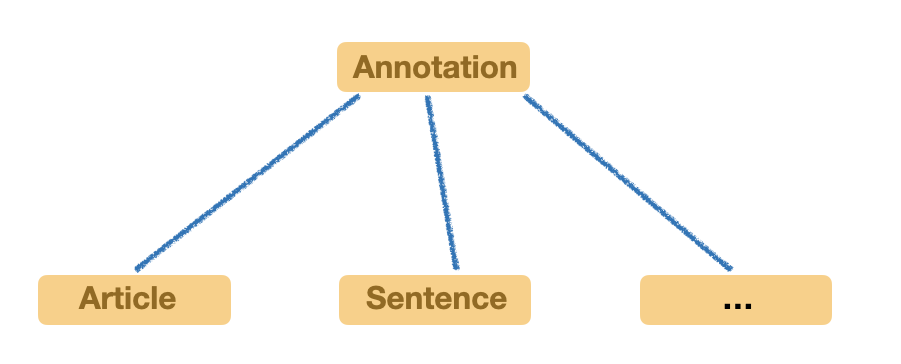


Actually, we not only supports text ontology but also audio, image and link which represent relationships between two entries.

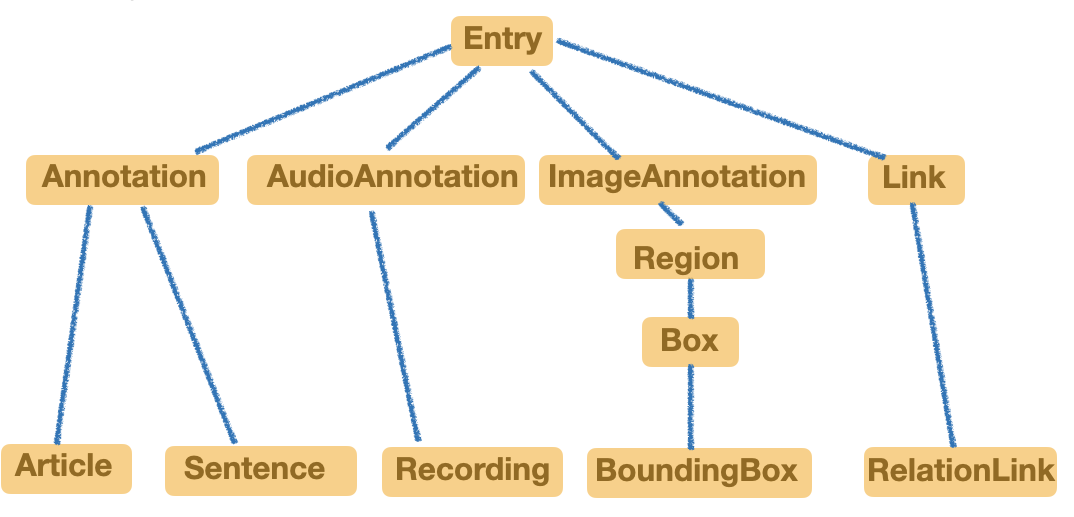


* `Annotation` is inherited by all text entries which usually has a span to retrieve partial text from the full text.
    * `Article`, as shown in our previous example, inherits annotation and contains `language` field to differentiate English and Germany. In the single DataPack example, English article has a span of English text in the DataPack. Likewise, Germany article has a span of Germany text in the DataPack. 
    * `Sentence` in our example is used to break down article, and we pass sentences into MT pipeline.
* `AudioAnnotation` is inherited by all audio entries which usually has an audio span to retrieve partial audio from the full audio.
    * `AudioUtterance` is an example subclass of `AudioAnnotation`, and it has extra speaker field denoting who is the speaker of the partial audio.
* `ImageAnnotation` is inherited by all image entries which usually has payload index pointing to a loaded image array.
    * `BoundingBox` is an example subclass of `ImageAnnotation`. As the picture shows, it has more inheritance relationships than other ontology classes due to the nature of CV objects. The advantage of forte ontology is that it supports complex inheritance, and users can inherit from existing ontology and add new ontology features for their needs.
* `Link` is inherited by all link-like entries which has parent and child.
    * `RelationLink` is an example subclass of `Link`, and it has a class attribute specifying the relation type. 

## Ontology in DataPack

Here we provide an illustration so that users can better understand the internal storage of DataPack. As we can see, text data, sentence and articles, are stored as span in `Annotations`. Their text data can be easily and efficienly retrieved by their spans.
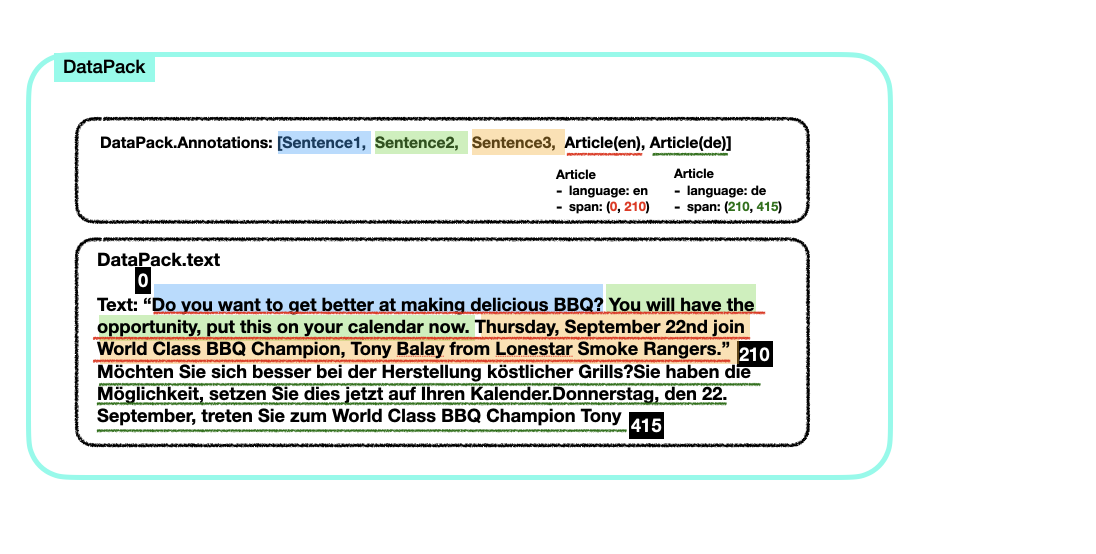

## Ontology in MultiPack

For comparison, here is an illustration of the internal storage of MultiPack. We can see that MultiPack wraps one source DataPack and one target DataPack. Article spans are based on two separate DataPack text.

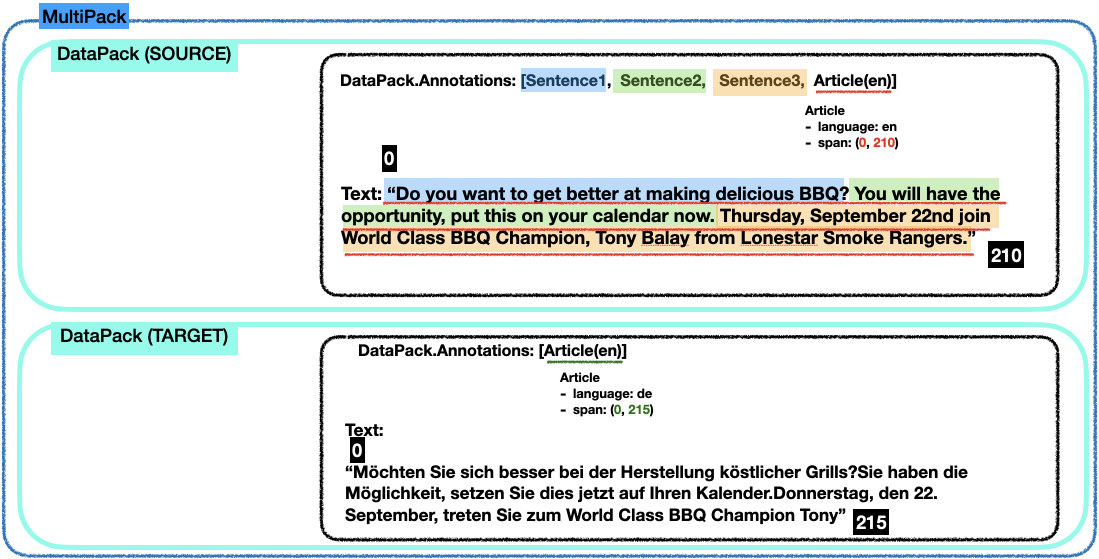

## DataPack and Multi-Modality
DataPack not only supports text data but also audio and image data.
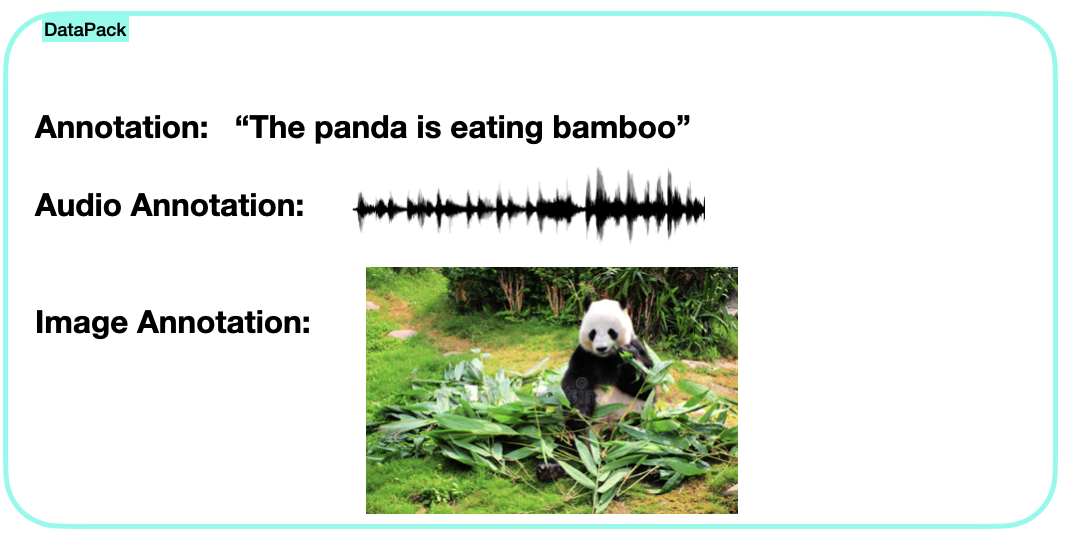